<a href="https://colab.research.google.com/github/chendingyan/Pytorch_Exercise/blob/master/460cw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework2: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

A PDF version of this notebook is also provided in case the figures do not render correctly.

**The deadline for submission is 19:00, Thu 14th February, 2019**

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

    100% |████████████████████████████████| 2.0MB 9.3MB/s 
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.0.1.post2 which is incompatible.
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution and max pooling operation. 

### YOUR TASK

- implement the forward pass for Conv2D and MaxPool2D
- You can only fill in the parts which are specified as "YOUR CODE HERE"
- You are **NOT** allowed to use the torch.nn module and the conv2d/maxpooling functions in torch.nn.functional

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Conv2D(nn.Module):
    
    def __init__(self, inchannel, outchannel, kernel_size, stride, padding, bias = True):
        
        super(Conv2D, self).__init__()
        
        self.inchannel = inchannel
        self.outchannel = outchannel
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        self.weights = nn.Parameter(torch.Tensor(outchannel, inchannel, 
                                                 kernel_size, kernel_size))
        self.weights.data.normal_(-0.1, 0.1)

        if bias:
            self.bias = nn.Parameter(torch.Tensor(outchannel, ))
            self.bias.data.normal_(-0.1, 0.1)
        else:
            self.bias = None
  
    def forward(self, x):
        
        ##############################################################
        #                       YOUR CODE HERE                       #       
        ##############################################################
        size = (x.shape[3] - self.kernel_size + 2* self.padding)/self.stride + 1
        Xunfold = F.unfold(x, kernel_size=self.kernel_size , padding=self.padding, stride = self.stride)
        kernels_flat = self.weights.view(self.outchannel, -1)
        output = torch.matmul(kernels_flat, Xunfold)
        if self.bias:
          output += self.bias
        output = output.view(x.shape[0], self.outchannel, size, size)
        
        
    
        ##############################################################
        #                       END OF YOUR CODE                     #
        ##############################################################
        

        return output


In [0]:
class MaxPool2D(nn.Module):
    
    def __init__(self, pooling_size):
        # assume pooling_size = kernel_size = stride
        
        super(MaxPool2D, self).__init__()
        
        self.pooling_size = pooling_size
        

    def forward(self, x):
        
        
        ##############################################################
        #                       YOUR CODE HERE                       #       
        ##############################################################
        size = int(x.shape[3]/self.pooling_size)
        Xunfold = F.unfold(x, kernel_size=self.pooling_size, stride = self.pooling_size)
        Xunfold = Xunfold.view(x.shape[0],x.shape[1],self.pooling_size*self.pooling_size,-1)
        output = torch.max(Xunfold,2)[0]
        output = output.view(x.shape[0],x.shape[1], size, size)


        ##############################################################
        #                       END OF YOUR CODE                     #
        ##############################################################
                
        
        return output

In [0]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2D(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2D(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2D(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
#         print('Finish one residual block')
        return out


In [0]:
# define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2D(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2D(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
#         print('Finish first convolution layer')
        x = self.layer1(x)
#         print('Finish first Resnet layer')
        x = self.layer2(x)
#         print('Finish second Resnet layer')
        x = self.layer3(x)
#         print('Finish third Resnet layer')
        x = self.layer4(x)
#         print('Finish fourth Resnet layer')
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)

        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

## Part 2 (40 points)

In this part, you will train the ResNet-18 defined in the previous part on the CIFAR-10 dataset. Code for loading the dataset, training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimiser

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

4. The bayesian optimisation method.  Bayesian optimization is an approach to optimizing objective functions that take a long time to evaluate. In the following case, I use Grid Search but also implement bayesian optimisation method. By using grid search and tune just one parameter(learning rate), it took me about 5 minutes to finish one epoch, so the whole training and tuning process is long. And I only tune learning rate by randomly choose some potentially good learning rate. If we use Bayesian Optimisation, it will automatically help us in hyperparameter searching, for example, we can find the most likely good learning rate and weight_decay in ADAM optimiser. 

**YOUR ANSWER FOR 2.4 HERE**

A:

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T


transform = T.ToTensor()


# load data

NUM_TRAIN = 49000
print_every = 100


data_dir = './data'
cifar10_train = dset.CIFAR10(data_dir, train=True, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10(data_dir, train=True, download=True, transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)


USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import time
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x.cuda())
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc


def train_part(model, optimizer, epochs=10):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(len(loader_train))
        start = time.time()
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x.cuda())
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f ,time = %.4f sec' % (e, t, loss.item(),(time.time() - start)))
                check_accuracy(loader_val, model)
                print()

In [0]:
# If you want to use Bayesian Optimisation method, you should run this
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# !mkdir -p drive
# !google-drive-ocamlfuse drive

# import os

# os.chdir("drive/Colab Notebooks") 

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 113598 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
# This is Bayesian Optimisation, it will automatically do hyperparameter tuning but takes time
# Get hint at https://github.com/fmfn/BayesianOptimization
# !pip install bayesian-optimization
# from bayes_opt import BayesianOptimization
# from bayes_opt.observer import JSONLogger
# from bayes_opt.event import Events
# from bayes_opt.util import load_logs

# is_continue = False

# def black_box_function(learning_rate, weight_decay):
#     #Function with unknown internals we wish to maximize, in this case, we want to tune
#     # learning rate and penalty coefficent and we want to maximize accuracy
#     learning_rate = 10 ** (-learning_rate)
#     weight_decay = 10 ** (-weight_decay)
#     model = ResNet18()
#     optimizer = optim.Adam(model.parameters(), learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)
#     train_part(model, optimizer, epochs = 10)
#     model.eval()

#     num_correct = 0
#     num_samples = 0
#     with torch.no_grad():
#         for x, y in loader_test:
#             x = x.to(device=device, dtype=dtype)  # move to device
#             y = y.to(device=device, dtype=torch.long)
#             scores = model(x)
#             _, preds = scores.max(1)
#             num_correct += (preds == y).sum()
#             num_samples += preds.size(0)
#         acc = float(num_correct) / num_samples
#         return acc
# #This is a constrained optimization technique, so you must specify the minimum and maximum values 
# #that can be probed for each parameter in order for it to work
# pbounds = {'learning_rate': (1, 4), 'weight_decay': (4, 10)}

# optimizer = BayesianOptimization(
#     f=black_box_function,
#     pbounds=pbounds,
#     random_state=1,
# )

# if is_continue is True:
#     load_logs(optimizer, logs=["./logs/logs.json"])

# logger = JSONLogger(path="./logs/logs_new.json")
# optimizer.subscribe(Events.OPTMIZATION_STEP, logger)
# print(optimizer.max)    

# optimizer.maximize(
#     init_points=4,
#     n_iter=6,
# )

# lr = 10 ** (-optimizer.max['params']['learning_rate'])
# weight_decay = 10 ** (-optimizer.max['params']['weight_decay'])

In [8]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
#Grid Search Method
model = ResNet18()
lr_matrix = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
best_acc = 0
best_lr = 0
for lr in lr_matrix:
  print('Learning rate is: ', lr)
  optimizer = optim.Adam(model.parameters(),lr = lr)
  train_part(model, optimizer, epochs = 5)
  acc = check_accuracy(loader_test, model)
  name = 'model_' + str(lr) + '.pt'
  torch.save(model.state_dict(), name)
  if acc > best_acc:
    best_acc = acc
    best_lr = lr
print(best_acc, best_lr)

##############################################################
#                       END OF YOUR CODE                     #
##############################################################


# define and train the network
model = ResNet18()

optimizer = optim.Adam(model.parameters(),lr = best_lr)

train_part(model, optimizer, epochs = 10)


# report test set accuracy

check_accuracy(loader_test, model)


# save the model
torch.save(model.state_dict(), 'model.pt')

('Learning rate is: ', 0.1)
766
Epoch: 0, Iteration 0, loss = 2.4532 ,time = 0.6097 sec
Checking accuracy on validation set
Got 102 / 1000 correct (10.20)
()
Epoch: 0, Iteration 100, loss = 2.1917 ,time = 47.0931 sec
Checking accuracy on validation set
Got 211 / 1000 correct (21.10)
()
Epoch: 0, Iteration 200, loss = 2.1076 ,time = 93.3836 sec
Checking accuracy on validation set
Got 153 / 1000 correct (15.30)
()
Epoch: 0, Iteration 300, loss = 2.0297 ,time = 139.5947 sec
Checking accuracy on validation set
Got 191 / 1000 correct (19.10)
()
Epoch: 0, Iteration 400, loss = 1.8166 ,time = 185.7515 sec
Checking accuracy on validation set
Got 240 / 1000 correct (24.00)
()
Epoch: 0, Iteration 500, loss = 1.8369 ,time = 231.8981 sec
Checking accuracy on validation set
Got 248 / 1000 correct (24.80)
()
Epoch: 0, Iteration 600, loss = 1.7484 ,time = 278.0711 sec
Checking accuracy on validation set
Got 304 / 1000 correct (30.40)
()
Epoch: 0, Iteration 700, loss = 1.5867 ,time = 324.2634 sec
Chec

In [0]:
## Part 3 (20 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

1. For low-level layer, feature map is more understandable by human beings, i.e. you can almost recognise the class of object from feature map. But when the layers to be deeper, the feature map extract abstract features so human can't understand it
2. The performance is not so good because we achieve the test set accuracy around 80%, but as we know, we can have better accuracy for CIFAR-10 dataset. To improve the performance, we can initialize weight using "Kaiming parameter" instead of random initialization. Also, i only tune learning rate due to time limits, if give more time, we can train the model for more epoch and tune more parameter, such as momentum, penalty coefficient and etc.
3. We can use confusion matrix to analyse the performance. Because here, we just know one value - accuarcy. We don't know if there is some class that has low accuracy and others high accuracy not not. By using confusion matrix, which gives us insight not only into the errors being made by a classifier but more importantly the types of errors that are being made.

**YOUR ANSWER FOR PART 3 HERE**

A:

<Figure size 576x396 with 0 Axes>

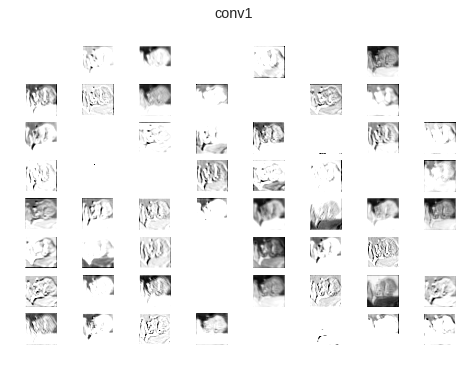

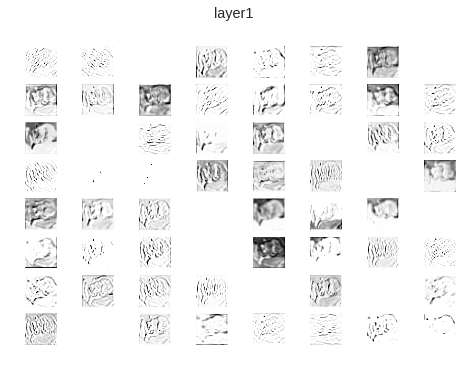

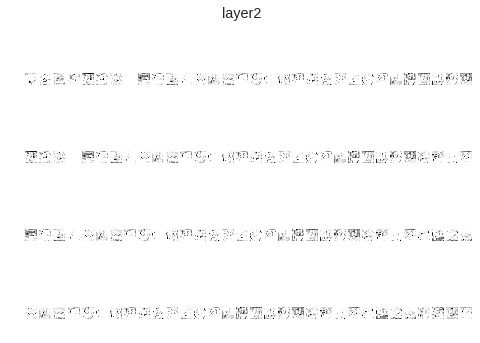

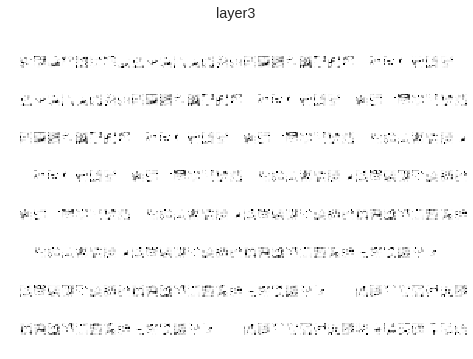

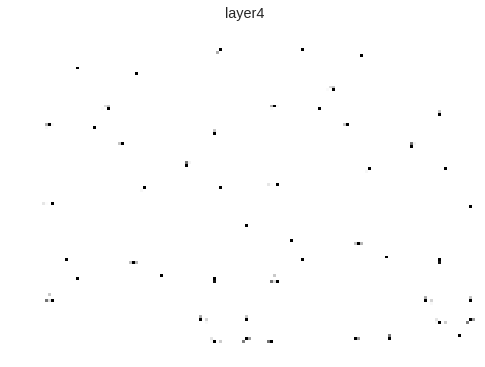

In [9]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')

**=============== END OF CW2 ===============**